In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Import models from scikit learn module:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, RandomForestRegressor
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [4]:
col_names = ['age', 'workclass', 'fnlwgt','education', 'education-num', 
'marital-status', 'occupation', 'relationship', 'race', 'sex',
'capital-gain','capital-loss', 'hours-per-week','native-country', 'income']
df = pd.read_csv('adult.data', header=None, names = col_names)

In [5]:
#Distribution of income
print(df.income.value_counts(normalize=True))

income
<=50K    0.75919
>50K     0.24081
Name: proportion, dtype: float64


In [6]:
#Clean columns by stripping extra whitespace for columns of type "object"
for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].str.strip()

In [7]:
feature_cols = ['age',
       'capital-gain', 'capital-loss', 'hours-per-week', 'sex','race', 'education', 'workclass', 'native-country']

In [8]:
#Create feature dataframe X with feature columns and dummy variables for categorical features
X = pd.get_dummies(df[feature_cols], drop_first=True)
#Create output variable y which is binary, 0 when income is less than 50k, 1 when it is greather than 50k
y = np.where(df['income']=='<=50K', 0, 1)

In [9]:
#Split data into a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)

In [10]:
#Instantiate random forest classifier, fit and score with default parameters
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)
print(f'Accuracy score for default random forest: {round(rfc.score(X_test, y_test)*100,3)}%')

Accuracy score for default random forest: 83.034%


In [11]:
#Tune the hyperparameter max_depth over a range from 1-25, save scores for test and train set
np.random.seed(0)
accuracy_train=[]
accuracy_test = []
depths = range(1,26)
for i in depths:
    rfc = RandomForestClassifier(max_depth=i)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    accuracy_test.append(accuracy_score(y_test, rfc.predict(X_test)))
    accuracy_train.append(accuracy_score(y_train, rfc.predict(X_train)))

In [12]:
#Find the best accuracy and at what depth that occurs
best_acc = np.max(accuracy_test)
best_depth = depths[np.argmax(accuracy_test)]
print(f'The highest accuracy on the test is achieved when depth: {best_depth}')
print(f'The highest accuracy on the test set is: {round(best_acc*100,3)}%')

The highest accuracy on the test is achieved when depth: 17
The highest accuracy on the test set is: 85.045%


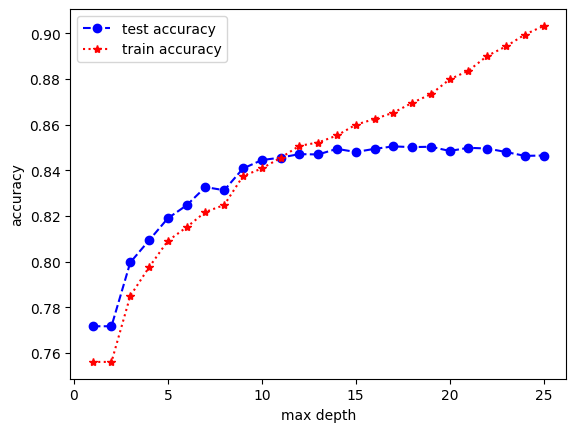

In [13]:
#Plot the accuracy scores for the test and train set over the range of depth values  
plt.plot(depths, accuracy_test,'bo--',depths, accuracy_train,'r*:')
plt.legend(['test accuracy', 'train accuracy'])
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.show()

In [14]:
#Save the best random forest model and save the feature importances in a dataframe
best_rfc = RandomForestClassifier(max_depth=best_depth)
best_rfc.fit(X_train, y_train)
feature_imp_df = pd.DataFrame(zip(X_train.columns, best_rfc.feature_importances_),  columns=['feature', 'importance'])
print('Top 5 random forest features:')
print(feature_imp_df.sort_values('importance', ascending=False).iloc[0:5])

Top 5 random forest features:
          feature  importance
1    capital-gain    0.249455
0             age    0.203080
3  hours-per-week    0.121128
2    capital-loss    0.084859
4        sex_Male    0.065929


In [15]:
#Create two new features, based on education and native country
df['education_bin'] = pd.cut(df['education-num'], [0,9,13,16], labels=['HS or less', 'College to Bachelors', 'Masters or more'])

feature_cols = ['age',
        'capital-gain', 'capital-loss', 'hours-per-week', 'sex', 'race','education_bin']

In [16]:
#Use these two new additional features and recreate X and test/train split
X = pd.get_dummies(df[feature_cols], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)

The highest accuracy on the test is achieved when depth: 9
The highest accuracy on the test set is: 84.431%


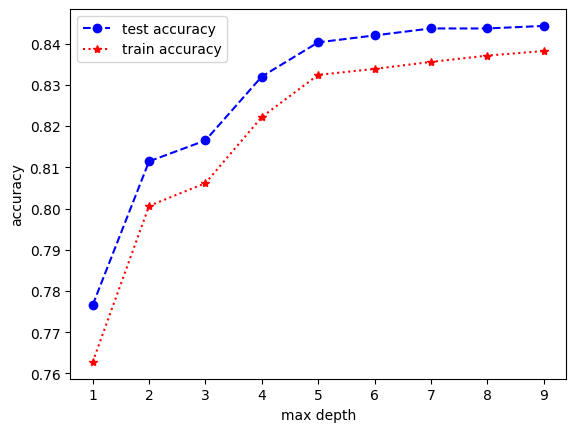

In [17]:
#Find the best max depth now with the additional two features
np.random.seed(0)
acc_train=[]
acc_test = []
depths = range(1,10)
for i in depths:
    rf = RandomForestClassifier(max_depth=i)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    acc_test.append(accuracy_score(y_test, rf.predict(X_test)))
    acc_train.append(accuracy_score(y_train, rf.predict(X_train)))
    
best_acc = np.max(acc_test)
best_depth = list(depths)[np.argmax(acc_test)]
print(f'The highest accuracy on the test is achieved when depth: {best_depth}')
print(f'The highest accuracy on the test set is: {round(best_acc*100,3)}%')

plt.figure(2)
plt.plot(depths, acc_test,'bo--',depths, acc_train,'r*:')
plt.legend(['test accuracy', 'train accuracy'])
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.show()

In [18]:
#Save the best model and print the two features with the new feature set
best_rfc = RandomForestClassifier(max_depth=best_depth)
best_rfc.fit(X_train, y_train)
feature_imp_df = pd.DataFrame(zip(X_train.columns, best_rfc.feature_importances_),  columns=['feature', 'importance'])
print('Top 5 random forest features:')
print(feature_imp_df.sort_values('importance', ascending=False).iloc[0:5])

Top 5 random forest features:
                          feature  importance
1                    capital-gain    0.326836
0                             age    0.201973
10  education_bin_Masters or more    0.130849
3                  hours-per-week    0.102162
2                    capital-loss    0.095188


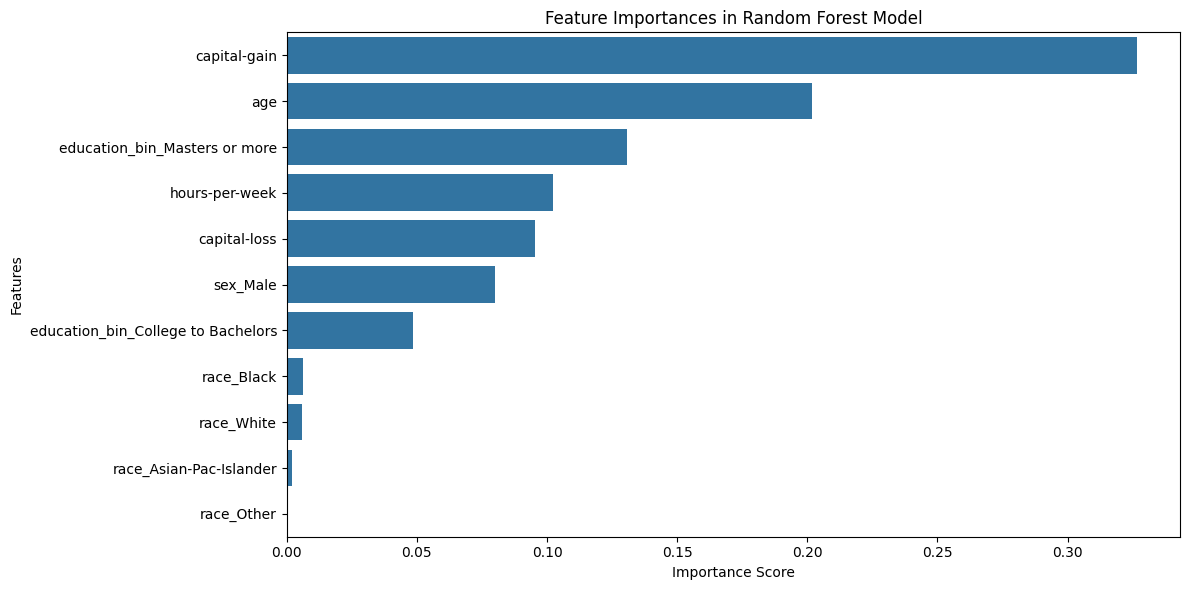

In [22]:
# Visualize feature importances with bar plot
plt.figure(figsize=(12, 6))
feature_importance = feature_imp_df.sort_values('importance', ascending=False)
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importances in Random Forest Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [19]:
# Precision, recall, f1 score and roc_auc score for the best model
acc = accuracy_score(y_test, best_rfc.predict(X_test))
precision = precision_score(y_test, best_rfc.predict(X_test))
recall = recall_score(y_test, best_rfc.predict(X_test))
f1 = f1_score(y_test, best_rfc.predict(X_test))
roc_auc = roc_auc_score(y_test, best_rfc.predict_proba(X_test)[:, 1])
print(f'Accuracy: {round(acc*100,3)}%')
print(f'Precision: {round(precision*100,3)}%')
print(f'Recall: {round(recall*100,3)}%')
print(f'F1 score: {round(f1*100,3)}%')
print(f'ROC AUC score: {round(roc_auc*100,3)}%')

Accuracy: 84.354%
Precision: 85.03%
Recall: 38.198%
F1 score: 52.715%
ROC AUC score: 86.962%


In [ ]:
# Plot ROC Curve
from sklearn.metrics import roc_curve

# Get prediction probabilities
y_pred_proba = best_rfc.predict_proba(X_test)[:, 1]

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Create ROC curve plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print some key points on the ROC curve
print("\nKey points on ROC curve:")
for i in range(0, len(fpr), len(fpr)//5):
    print(f"At threshold {thresholds[i]:.2f}:")
    print(f"False Positive Rate: {fpr[i]:.3f}")
    print(f"True Positive Rate: {tpr[i]:.3f}\n")

In [20]:
# Cross validation for the best model
from sklearn.model_selection import cross_val_score
cross_val_scores = cross_val_score(best_rfc, X, y, cv=5)
print(f'Cross-validation scores: {cross_val_scores}')
print(f'Mean cross-validation score: {round(np.mean(cross_val_scores)*100,3)}%')
print(f'Standard deviation of cross-validation scores: {round(np.std(cross_val_scores)*100,3)}%')
print(f'Best model: {best_rfc}')
print(f'Best model parameters: {best_rfc.get_params()}')


Cross-validation scores: [0.8334101  0.83707002 0.83445946 0.83568796 0.84029484]
Mean cross-validation score: 83.618%
Standard deviation of cross-validation scores: 0.239%
Best model: RandomForestClassifier(max_depth=9)
Best model parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
